In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [17]:
# Setup
base_dir = 'food'
image_size = (224, 224)
batch_size = 32
num_classes = 80  # kamu bilang ada 80 kelas

# Preprocessing sesuai MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Simpan urutan label
label_map = train_generator.class_indices
class_names = list(label_map.keys())

# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze 30 lapisan terakhir saja
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Save model
model.save('mobilenetv2_food_finetune_v2.keras')

Found 32000 images belonging to 80 classes.
Found 7999 images belonging to 80 classes.
Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 460s 454ms/step - accuracy: 0.0178 - loss: 4.7592 - val_accuracy: 0.0779 - val_loss: 4.1096
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 457s 455ms/step - accuracy: 0.0616 - loss: 4.2055 - val_accuracy: 0.2144 - val_loss: 3.5900
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 452s 451ms/step - accuracy: 0.1424 - loss: 3.7710 - val_accuracy: 0.2994 - val_loss: 3.1373
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 453s 451ms/step - accuracy: 0.2161 - loss: 3.3894 - val_accuracy: 0.3780 - val_loss: 2.7621
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 453s 451ms/step - accuracy: 0.2815 - loss: 3.0702 - val_accuracy: 0.4368 - val_loss: 2.4637
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.3225 - loss: 2.8318 - val_accuracy: 0.4797 - val_loss: 2.2361
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 452s 450ms/step - accuracy: 0.3666 - loss: 2.6224 - val_accu

In [18]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 80)             │        10,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433,842 (24.54 MB)

 Trainable params: 1,899,792 (7.25 MB)

 Non-trainable params: 734,464 (2.80 MB)

 Optimizer params: 3,799,586 (14.49 MB)

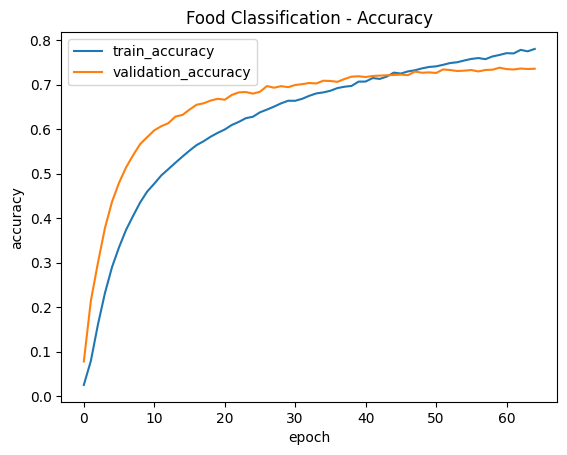

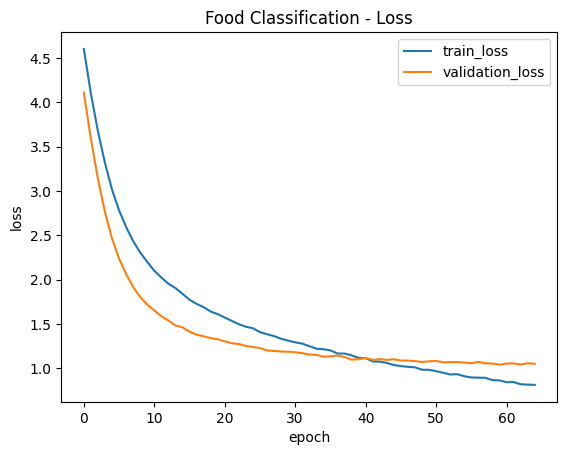

In [19]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

# Memvisualisasikan grafik akurasi dan loss dari history pelatihan model
plot_accuracy(history, 'Food Classification - Accuracy')
plot_loss(history, 'Food Classification - Loss')

In [20]:
# Langkah 1: Menggunakan data validasi penuh untuk evaluasi
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False  # Jangan acak agar urutan data tetap untuk evaluasi
)

# Memuat model yang sudah disimpan
model = load_model('mobilenetv2_food_finetune_v2.keras')

# Melakukan prediksi pada seluruh data validasi
val_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=val_steps)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

# Cek jumlah kelas pada data validasi
num_classes_val = len(np.unique(true_labels))
print(f"Jumlah kelas pada data validasi: {num_classes_val}")

# Mengambil nama kelas dari generator
class_names = list(validation_generator.class_indices.keys())
print(f"Jumlah kelas yang terbaca oleh validation_generator: {len(class_names)}")

# hitung akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Akurasi model: {accuracy * 100:.2f}%')

# Menghitung classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Menampilkan seluruh baris pada dataframe
pd.set_option('display.max_rows', None)

# Menampilkan classification report dalam bentuk tabel
print("Classification Report:")
print(df_report)

Found 7999 images belonging to 80 classes.
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step
Jumlah kelas pada data validasi: 80
Jumlah kelas yang terbaca oleh validation_generator: 80
Akurasi model: 73.16%
Classification Report:
                      precision    recall  f1-score      support
baby_back_ribs         0.808989  0.720000  0.761905   100.000000
baklava                0.709091  0.780000  0.742857   100.000000
beef_tartare           0.739583  0.710000  0.724490   100.000000
beet_salad             0.539823  0.610000  0.572770   100.000000
beignet                0.710744  0.860000  0.778281   100.000000
bibimbap               0.830189  0.880000  0.854369   100.000000
bruschetta             0.558559  0.620000  0.587678   100.000000
caesar_salad           0.666667  0.720000  0.692308   100.000000
cannoli                0.670103  0.650000  0.659898   100.000000
caprese_salad          0.571429  0.560000  0.565657   100.000000
carrot_cake            0.777778  0.630000  0.696133   100.000

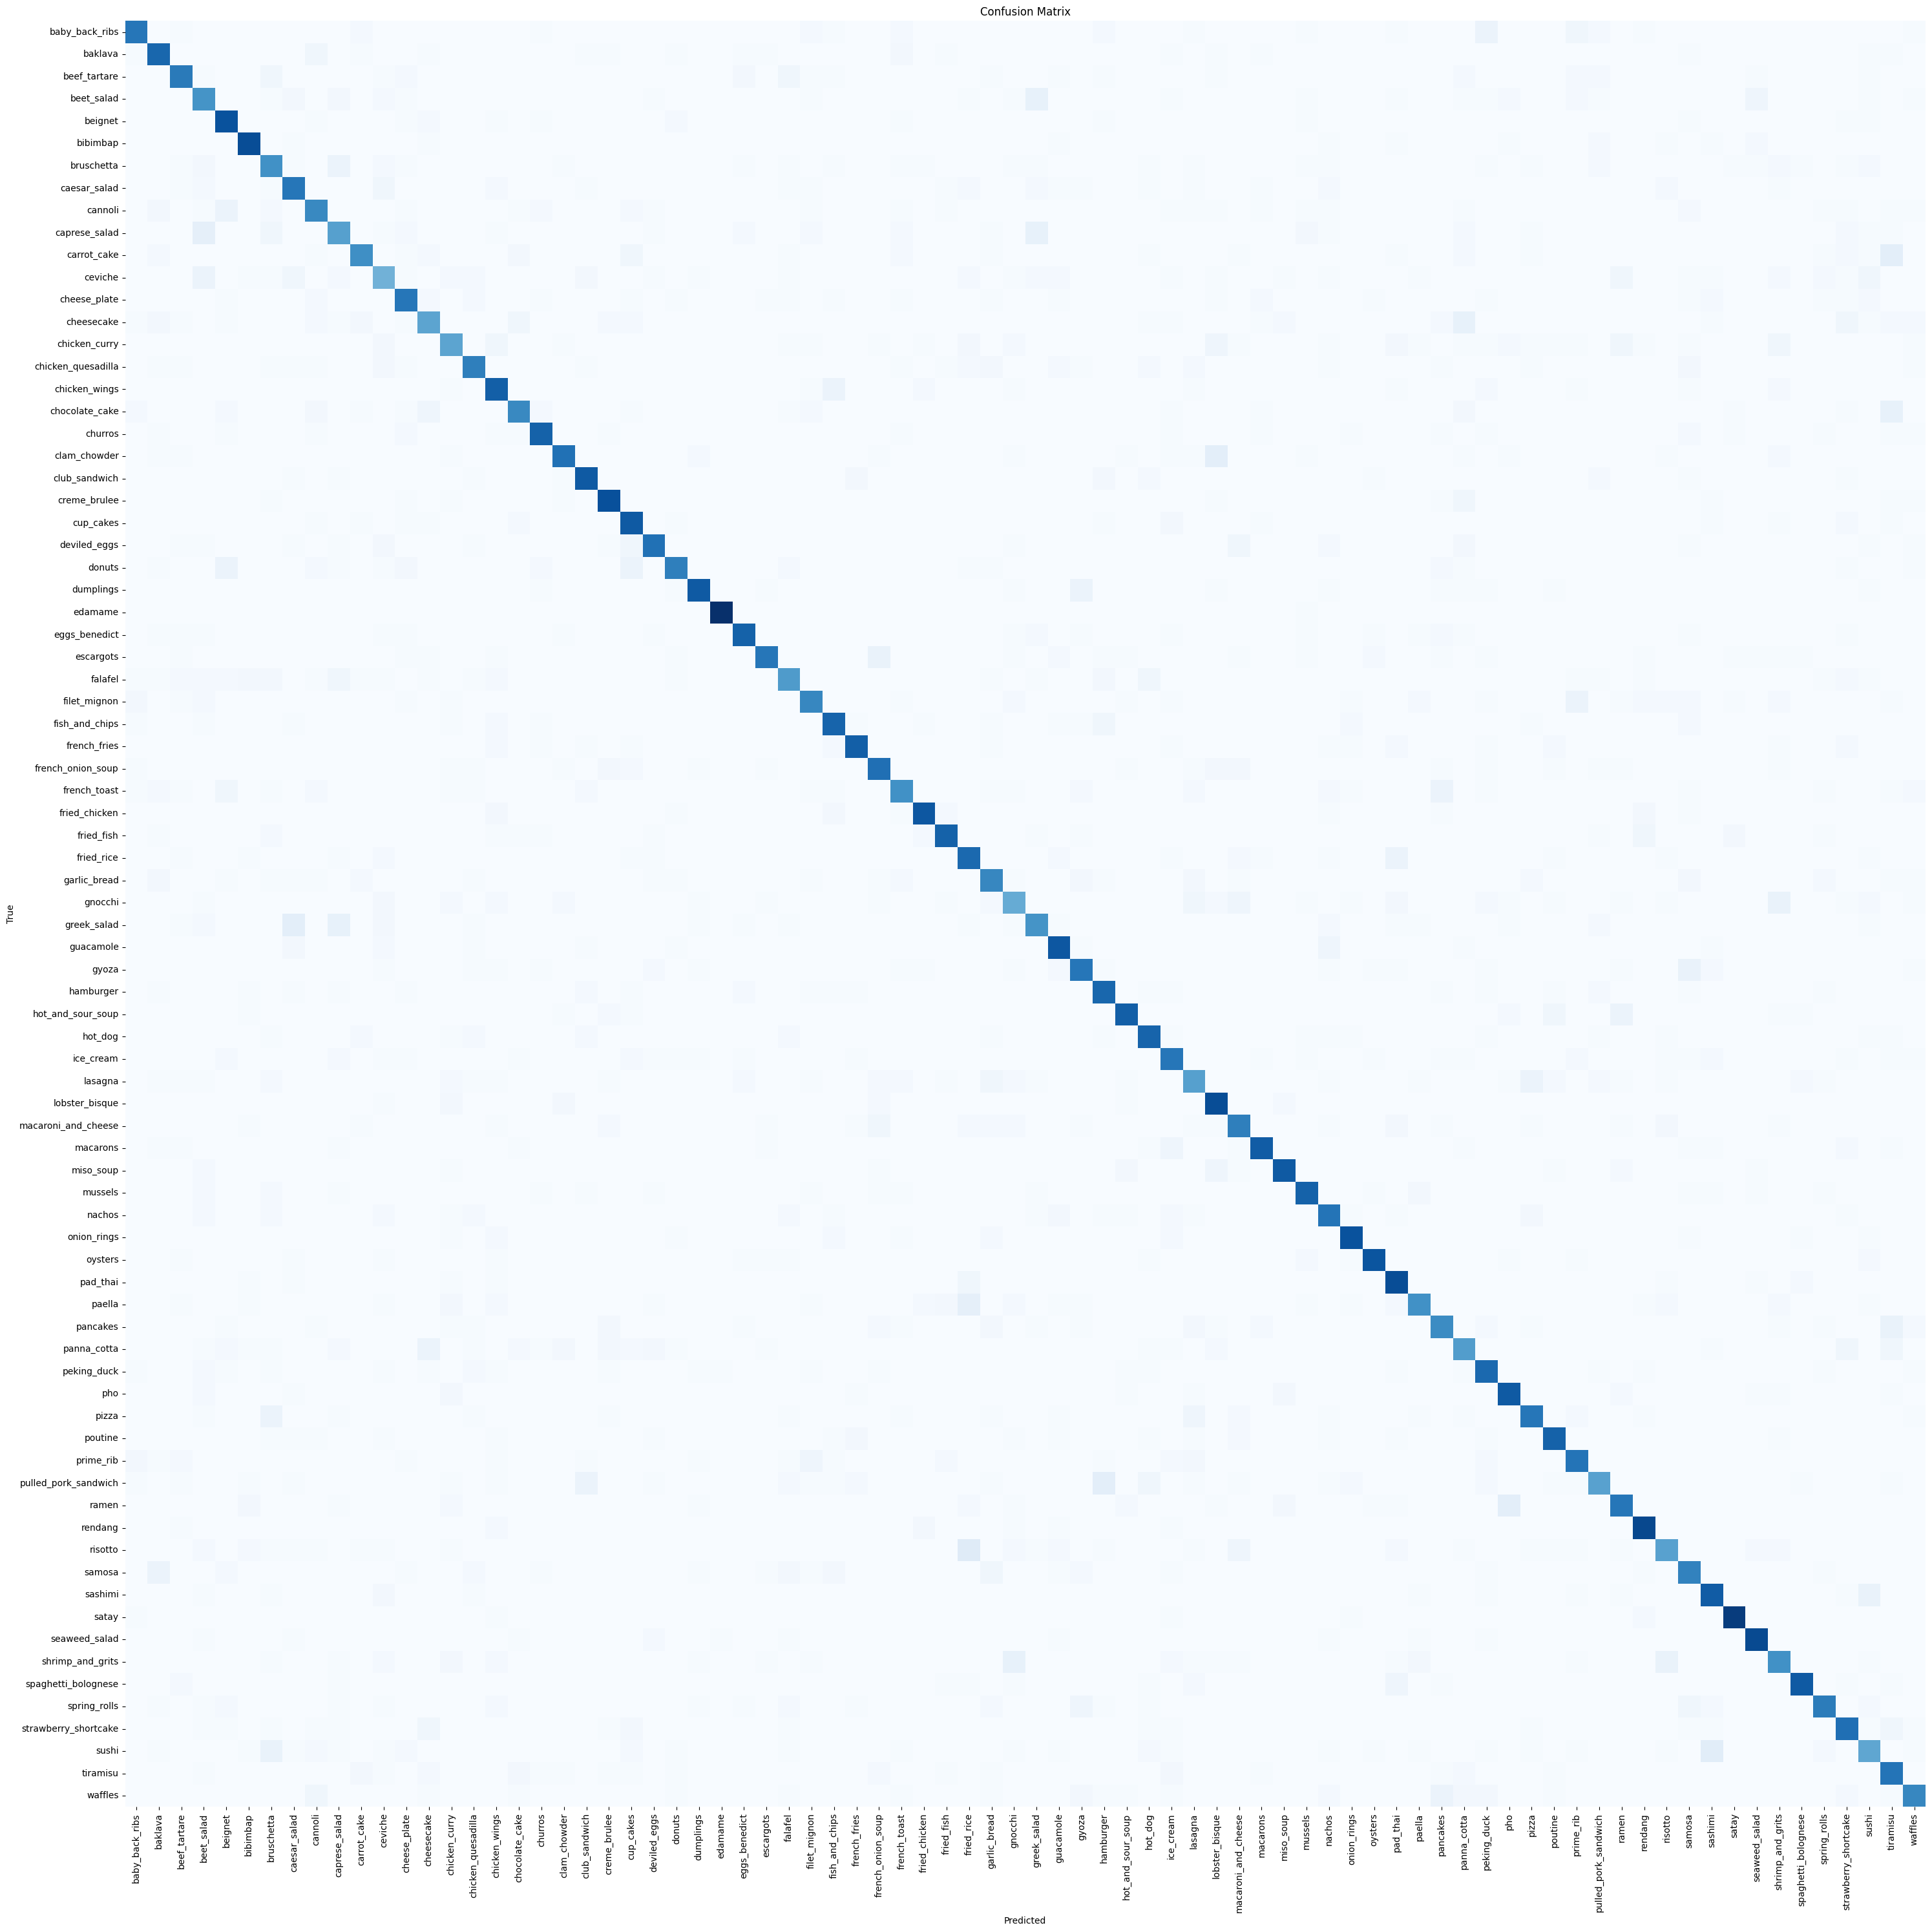

In [21]:
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(len(class_names)))

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=False, fmt='g', vmin=0, cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()